<a href="https://colab.research.google.com/github/edison0828/generative_ai/blob/main/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 研究報告/論文摘要與論證鏈提取器 (二階段 CoT) 🚀

這個應用程式利用大型語言模型 (LLM) 和鏈式思考 (Chain-of-Thought, CoT) 的能力，幫助使用者快速理解研究論文的核心內容和論證邏輯。模型使用GPT-4.1 nano，可以支援1M token的上下文，很適合用在論文這種包含大量文字的輸入。

**🎯 核心功能：**

輸入一篇研究論文的文本（可以是全文、摘要或關鍵段落），應用程式將：
1.  **生成精煉的論文摘要：** 涵蓋研究背景、問題、方法、關鍵發現與結論。
2.  **提取並展示核心論證鏈：** 清晰地呈現作者如何從提出問題，透過研究方法和證據，最終推導出研究結論的邏輯流程。

**💡 CoT 應用方式 (二階段)：**

為了提升分析的深度和輸出的品質，我採用了二階段 CoT 的方法：

1.  **第一階段 (內部思考與結構化分析 - Analyzer/Planner):**
    *   **目標：** LLM 深入閱讀輸入文本，進行逐步思考，識別並提取論文的關鍵組成部分（如問題、目標、方法、證據、結論等），並梳理它們之間的初步邏輯關係。
    *   **輸出：** 結構化的分析筆記（供第二階段使用，也會展示給使用者參考其思考過程）。

2.  **第二階段 (使用者摘要與論證鏈生成 - Writer):**
    *   **目標：** 基於第一階段的結構化分析結果，LLM 生成一份專業、清晰、易於理解的論文摘要和核心論證鏈說明。
    *   **輸出：** 最終呈現給使用者的摘要和論證鏈。


#### 1. 安裝必要的套件

In [4]:
!pip install aisuite[all] -q
!pip install gradio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00


In [5]:
import os
from google.colab import userdata

### 2. 設定 API 金鑰

In [12]:
import os
import warnings
warnings.filterwarnings("ignore", message="Cannot retrieve RAM information")

from google.colab import userdata


# 【使用 OpenAI】
try:
    api_key = userdata.get('OpenAI')
    os.environ['OPENAI_API_KEY'] = api_key
    default_provider = "openai"
    default_model_analyzer = "gpt-4.1-mini"
    default_model_writer = "gpt-4.1-mini"
    print("使用 OpenAI API 金鑰")
except Exception as e:
    print(f"無法獲取 OpenAI 金鑰: {e}")
    if 'default_provider' not in locals(): default_provider = None

    # --- 檢查是否有設定成功 ---
if default_provider:
    print(f"預設 Provider: {default_provider}")
    print(f"預設 Analyzer Model: {default_model_analyzer}")
    print(f"預設 Writer Model: {default_model_writer}")
else:
    print("🚨 警告：請取消註解並設定至少一個有效的 API 金鑰區塊！🚨")

使用 OpenAI API 金鑰
預設 Provider: openai
預設 Analyzer Model: gpt-4.1-mini
預設 Writer Model: gpt-4.1-mini


### 3. 匯入 AISuite 並定義通用呼叫函式

In [13]:
import aisuite as ai
import gradio as gr


def call_llm(system_prompt="請用台灣使用者習慣的繁體中文回覆。",
             user_prompt="Hi",
             provider="openai",
             model="gpt-4o",
             temperature=0.5 # 為分析任務稍微降低隨機性
             ):
    """
    通用的 LLM API 呼叫函式
    """
    try:
        client = ai.Client()
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]

        response = client.chat.completions.create(
            model=f"{provider}:{model}",
            messages=messages,
            temperature=temperature,
        )

        return response.choices[0].message.content.strip()

    except Exception as e:
        print(f"LLM API 呼叫失敗 (Provider: {provider}, Model: {model}): {e}")
        error_message = f"發生錯誤：{e}\n"
        error_message += f"請檢查您的 API 金鑰、模型名稱 ({provider}:{model}) 是否正確，以及網路連線。"
        if "context length" in str(e).lower():
             error_message += "\n錯誤可能與輸入文本過長有關，請嘗試縮短輸入或使用支援更長上下文的模型。"
        return error_message

### 4. 定義二階段 CoT 的 System Prompts

In [14]:
# --- 第一階段：內部思考與結構化分析 ---
system_analyzer = """
你是位專業的科研助理，任務是深入分析使用者提供的研究論文文本（可能是摘要、引言、方法、結果、討論或全文片段）。
請**逐步思考**並**提取**以下關鍵信息，形成結構化的分析筆記。**請勿直接生成最終摘要或面向一般用戶的解釋**，專注於內部結構化分析。

分析步驟與輸出格式如下（請嚴格遵守）：

1.  **研究背景與核心問題：** 這篇論文要解決什麼主要問題？基於什麼樣的現有知識或研究缺口？
2.  **研究目標/假設：** 作者明確提出的研究目標，或是想要驗證的科學假設是什麼？
3.  **核心方法/途徑：** 作者採用了哪些主要的研究方法、實驗設計、數據來源、分析技術或理論框架？
4.  **關鍵證據/結果：** 論文中呈現了哪些最重要的實驗數據、觀察結果或核心發現來支持他們的論點？列出要點。
5.  **主要結論/貢獻：** 作者基於研究結果得出了哪些核心結論？他們認為這項研究的主要貢獻是什麼？
6.  **初步論證鏈梳理：** 簡要描述從「問題」到「方法」到「證據/結果」再到「結論」的邏輯流程。

請將分析結果整理成清晰的條列式或段落式筆記。
"""

# --- 第二階段：使用者摘要與論證鏈生成 ---
system_writer = """
你是位優秀的學術寫作專家和科學傳播者。你的任務是根據提供的「內部思考分析筆記」，為使用者生成一份清晰、專業且易於理解的論文摘要和核心論證鏈。

請產出以下兩個部分：

**1. 論文摘要：**
   *   根據分析筆記，撰寫一段精煉的摘要。
   *   摘要應包含研究背景、核心問題、主要方法、關鍵發現和最終結論。
   *   語言需專業、流暢、準確。

**2. 核心論證鏈：**
   *   根據分析筆記，清晰地闡述論文的核心論證邏輯。
   *   說明作者是如何從「研究出發點（問題/背景）」出發，透過「採用的方法/途徑」，獲得「關鍵的支撐證據/結果」，最終推導出「結論/貢獻」的。
   *   可以使用條列式、流程說明或段落敘述，重點在於清晰地展示各環節間的邏輯聯繫。

請確保輸出的內容嚴格基於提供的分析筆記，並以專業、易懂的方式呈現給使用者。請使用台灣使用者習慣的繁體中文。
"""

### 5. 建立二階段分析函式

In [15]:
def analyze_paper(paper_text,
                  provider_analyzer=default_provider, model_analyzer=default_model_analyzer,
                  provider_writer=default_provider, model_writer=default_model_writer):
    """
    執行二階段 CoT 論文分析的函式
    """
    if not paper_text:
        return "請輸入論文文本。", "請輸入論文文本。"
    if not provider_analyzer or not provider_writer:
         return "錯誤：未設定有效的 LLM Provider。", "錯誤：未設定有效的 LLM Provider。"

    print("--- 開始第一階段：內部思考與結構化分析 ---")
    analyzer_prompt = f"這是使用者提供的論文文本：\n\n---\n{paper_text}\n---\n\n請根據上述文本，執行深入的結構化分析。"
    internal_analysis = call_llm(system_analyzer, analyzer_prompt,
                                provider=provider_analyzer,
                                model=model_analyzer)
    print(f"第一階段分析結果：\n{internal_analysis[:500]}...\n")

    # 檢查第一階段是否成功返回分析結果
    if internal_analysis.startswith("發生錯誤："):
        return internal_analysis, "第一階段分析失敗，無法進行第二階段。"

    print("--- 開始第二階段：使用者摘要與論證鏈生成 ---")
    writer_prompt = f"這是對論文的內部思考分析筆記：\n\n---\n{internal_analysis}\n---\n\n請根據這份筆記，生成專業的論文摘要和核心論證鏈。"
    final_output = call_llm(system_writer, writer_prompt,
                            provider=provider_writer,
                            model=model_writer)
    print(f"第二階段生成結果：\n{final_output[:500]}...\n")

    # 檢查第二階段是否成功返回結果
    if final_output.startswith("發生錯誤："):
         return internal_analysis, final_output # 第二步失敗，返回第一步的結果

    return internal_analysis, final_output

### 6. 使用 Gradio 建立 Web App 介面 (支援 PDF 上傳)

In [16]:

# 安裝 PDF 處理庫
!pip install pymupdf -q

import gradio as gr
import fitz
import traceback

def extract_text_from_pdf(pdf_file_object):
    """
    從 Gradio 上傳的 PDF 文件對象中提取文本。
    """
    if pdf_file_object is None:
        return None, "錯誤：沒有上傳檔案。"

    try:
        pdf_path = pdf_file_object.name
        doc = fitz.open(pdf_path)
        full_text = ""
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            full_text += page.get_text("text") # 提取純文本
            full_text += "\n"
        doc.close()
        if not full_text.strip():
             return None, "警告：成功開啟 PDF，但未能提取任何文本。檔案可能是圖片掃描檔或為空。"
        return full_text, None
    except Exception as e:
        print(f"讀取 PDF 時發生錯誤: {e}")
        print(traceback.format_exc())
        error_message = f"讀取 PDF 時發生錯誤：{e}。\n請確保檔案是有效的 PDF 且未加密。"
        # 檢查是否為常見的圖片 PDF 問題
        if "cannot open broken document" in str(e).lower() or "no objects found" in str(e).lower():
             error_message += "\n檔案可能已損壞。"
        # 懷疑是圖片，提示用戶
        error_message += "\n如果 PDF 是掃描的圖片，此工具目前無法處理。"
        return None, error_message

def process_input(text_input, pdf_file):
    """
    處理文本輸入或 PDF 上傳，然後調用分析函式。
    """
    extracted_text = ""
    error_msg = None
    final_text_to_analyze = ""

    if pdf_file is not None:
        print("處理上傳的 PDF...")
        extracted_text, error_msg = extract_text_from_pdf(pdf_file)
        if error_msg:
            print(f"PDF 處理錯誤: {error_msg}")
            if text_input:
                 print("PDF 處理失敗，但偵測到文本框輸入，將使用文本框內容。")
                 final_text_to_analyze = text_input
                 error_msg += "\n\n已使用文本框中的內容進行分析。"
            else:
                return f"錯誤：{error_msg}", "請檢查 PDF 檔案或在文本框中輸入內容。"
        elif extracted_text:
             print("PDF 文本提取成功。")
             final_text_to_analyze = extracted_text
             # 如果同時有文本框輸入和 PDF，合併
             if text_input:
                 final_text_to_analyze = text_input + "\n\n" + extracted_text
    elif text_input:
        print("處理文本框輸入...")
        final_text_to_analyze = text_input
    else:
        return "請在文本框輸入內容或上傳 PDF 檔案。", "請在文本框輸入內容或上傳 PDF 檔案。"

    if not final_text_to_analyze.strip():
         return f"錯誤：{error_msg if error_msg else '未能從輸入中獲取有效文本。'}", "無法進行分析。"


    print(f"準備將以下文本送去分析 (長度: {len(final_text_to_analyze)}):\n{final_text_to_analyze[:300]}...")
    analysis_result, final_output = analyze_paper(final_text_to_analyze)

    if error_msg and not analysis_result.startswith("錯誤："):
        analysis_result = f"**PDF 處理信息：** {error_msg}\n\n---\n\n**第一階段分析：**\n{analysis_result}"

    return analysis_result, final_output


# --- Gradio 介面定義 ---
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🚀 研究報告/論文摘要與論證鏈提取器 (二階段 CoT)")
    gr.Markdown("請在下方**貼入論文文本**或**上傳 PDF 檔案**。AI 將進行兩階段分析。")

    with gr.Row():
        with gr.Column(scale=2):
            paper_input = gr.Textbox(lines=10, label="貼入論文文本 (選項一)", placeholder="請在此貼入論文內容...")
            pdf_input = gr.File(label="或 上傳 PDF 檔案 (選項二)", file_types=['.pdf'])
            submit_btn = gr.Button("✨ 開始分析", variant="primary")
        with gr.Column(scale=3):
            gr.Markdown("### 🧠 第一階段：內部思考與結構化分析 (CoT)")
            output_analysis = gr.Textbox(lines=13, label="分析過程預覽 / 處理信息", interactive=False)
            gr.Markdown("### 📄 第二階段：使用者摘要與論證鏈")
            output_final = gr.Textbox(lines=13, label="最終輸出結果", interactive=False)

    # 清除按鈕
    def clear_all():
        return "", None, "", ""
    clear_btn = gr.Button("清除所有內容")
    clear_btn.click(clear_all, inputs=[], outputs=[paper_input, pdf_input, output_analysis, output_final])

    submit_btn.click(
        process_input,
        inputs=[paper_input, pdf_input], # 接收兩個輸入
        outputs=[output_analysis, output_final]
    )

    gr.Markdown("---")
    gr.Markdown("💡 **提示：** 分析結果的品質取決於輸入文本/PDF內容的清晰度、完整性以及所選 LLM 的能力。如果文本過長，可能超出模型的上下文限制。處理 PDF 可能需要一些時間。")
    gr.Markdown(f"使用的分析模型 (Analyzer): `{default_provider}:{default_model_analyzer}` | 生成模型 (Writer): `{default_provider}:{default_model_writer}`")

### 7. 啟動 Gradio 應用程式

In [17]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0ce838757eb470bf0d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


處理上傳的 PDF...
PDF 文本提取成功。
準備將以下文本送去分析 (長度: 59437):
Deep Residual Learning for Image Recognition
Kaiming He
Xiangyu Zhang
Shaoqing Ren
Jian Sun
Microsoft Research
{kahe, v-xiangz, v-shren, jiansun}@microsoft.com
Abstract
Deeper neural networks are more difﬁcult to train. We
present a residual learning framework to ease the training
of networks that a...
--- 開始第一階段：內部思考與結構化分析 ---
第一階段分析結果：
1. 研究背景與核心問題：
- 深度神經網絡在圖像識別任務中表現優異，網絡深度被證明對性能提升至關重要（VGG、GoogLeNet等深度模型）。
- 然而，隨著網絡層數增加，訓練深層網絡變得困難，出現「退化問題」（degradation problem）：更深的網絡反而在訓練誤差和測試誤差上表現更差，非由過擬合引起。
- 傳統問題如梯度消失/爆炸已被批改（透過批量正規化、初始化等），但退化問題仍未解決。
- 現有優化方法無法有效找到深層網絡中接近淺層網絡性能的解。
- 研究缺口在於如何設計結構或方法，讓極深網絡能有效訓練且提升性能。

2. 研究目標/假設：
- 目標：提出一種新的學習框架「殘差學習（Residual Learning）」，以解決深層網絡的退化問題，使得更深的網絡能夠更容易訓練並獲得更好的性能。
- 假設：相比直接學習期望的輸入輸出映射H(x)，學習「殘差函數」F(x) = H(x) - x（即將原映射重寫為F(x) + x）更容易優化。若最優映射接近恒等映射，則優化殘差函數更簡單（只需將殘差推向零）。
- 預期殘差網絡能在不增加計算複雜度的情況下，顯著提升深層網絡的訓...

--- 開始第二階段：使用者摘要與論證鏈生成 ---
第二階段生成結果：
**1. 論文摘要：**

深度神經網絡在圖像識別領域展現卓越性能，然而隨著網絡層數增加，訓練過程中出現的退化問題導致更深層網絡反而表現

## 實際使用截圖

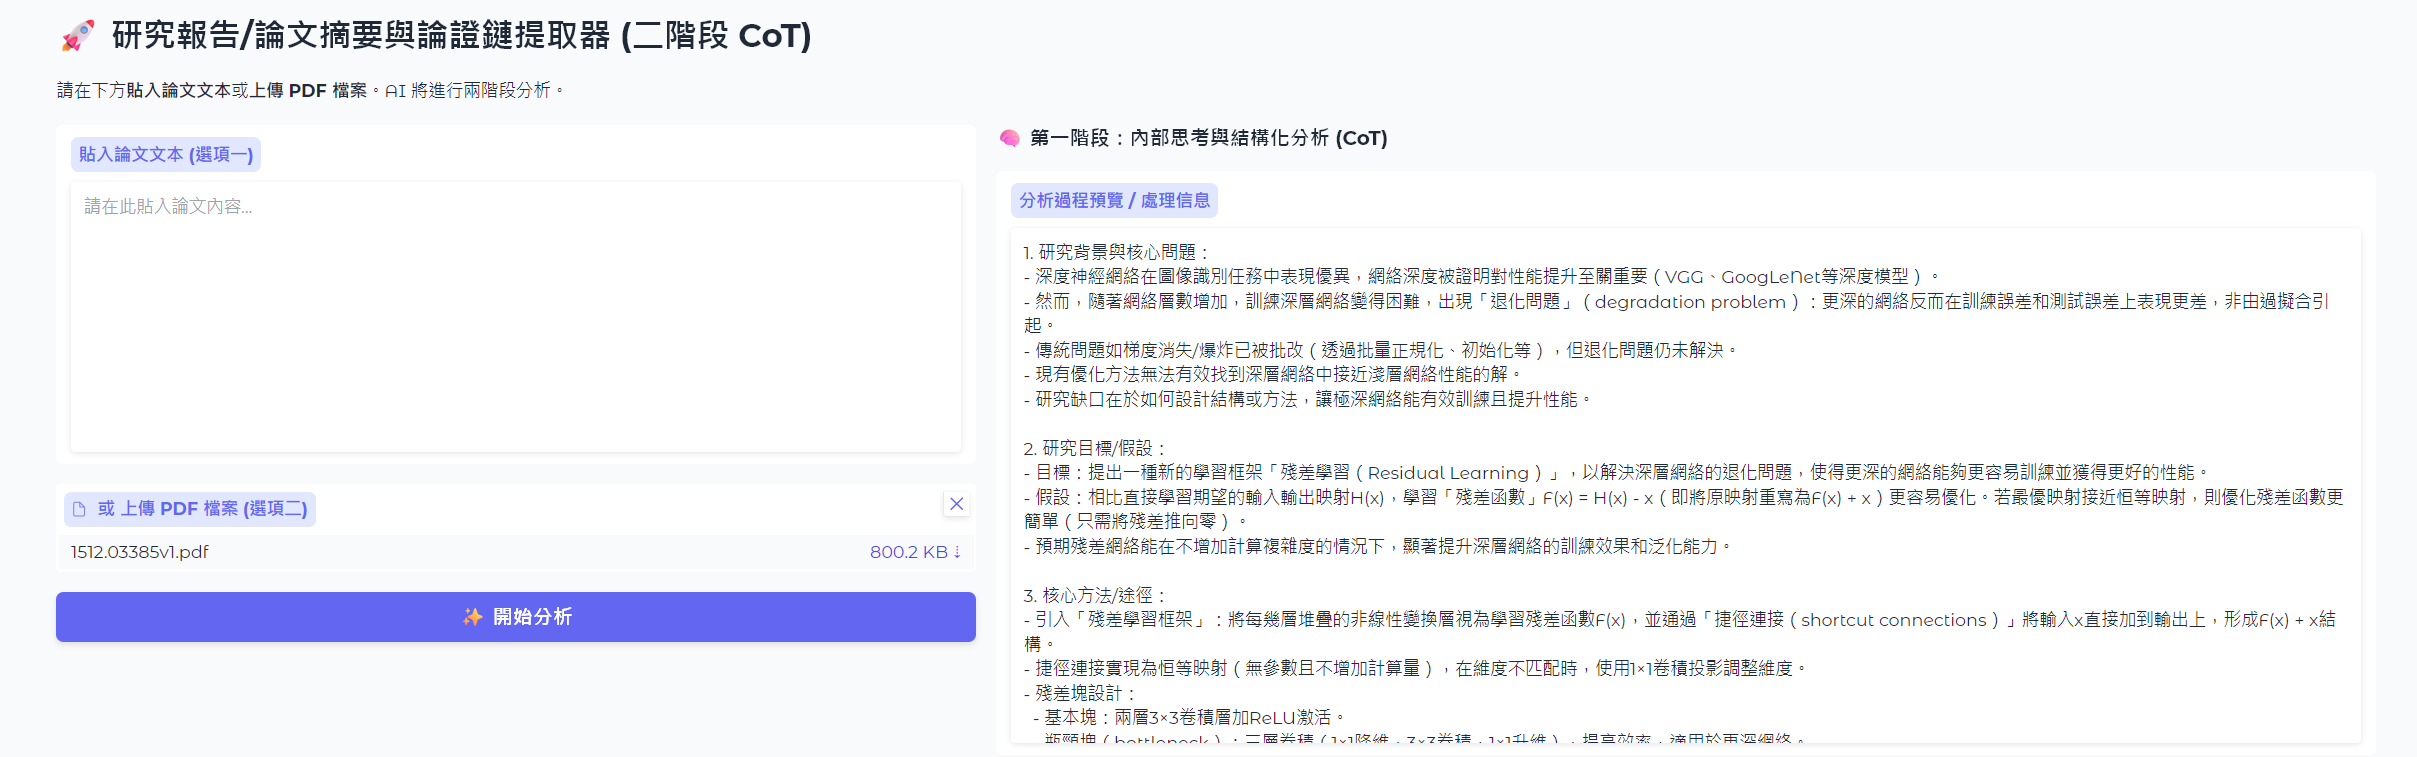

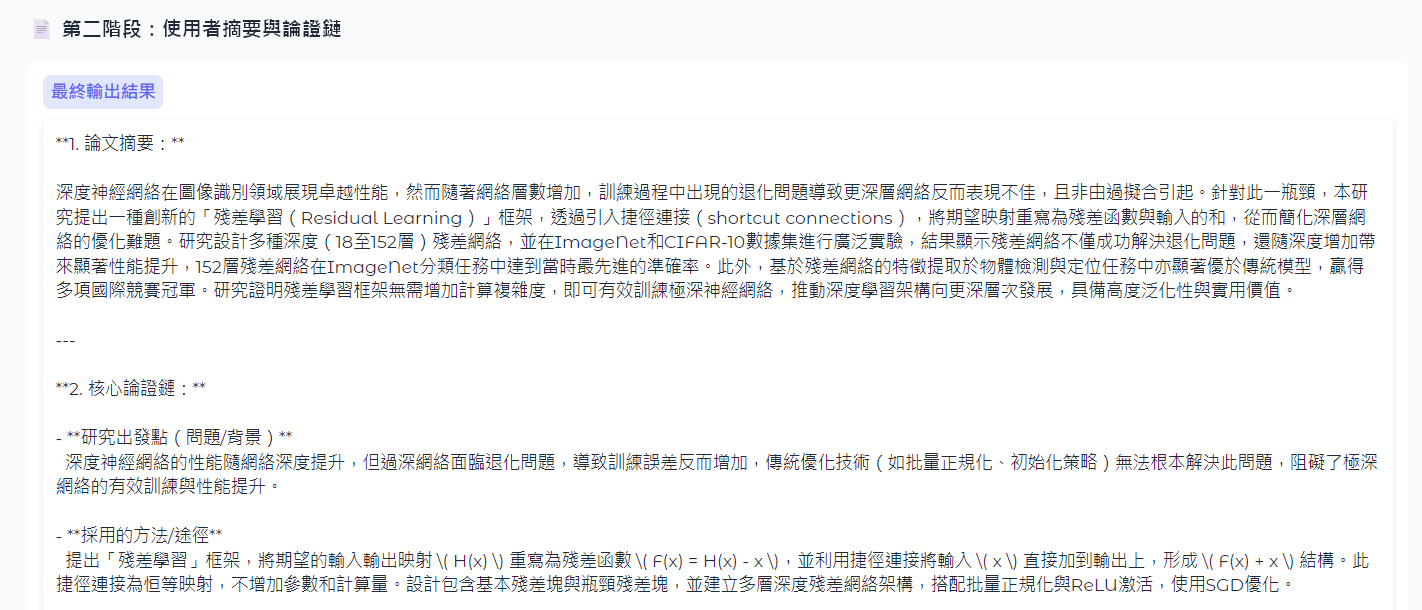